In [1]:
import torch
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from tqdm import tqdm
import torch.optim as optim
import torch.nn.functional as F
from utils.dataset import CocoDataset
from utils.plots import plot_rgb, reconstruct_lab
from utils.models import save_model, load_model

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

TO DO:
- add unet generator
- try out different losses (gan loss, wgan, gan loss with l1 term)
- try to add layers, dropout, remove/add batchnorm (in general test architectures)
- try patchgan discriminator

## Data Import

In [3]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

In [4]:
dataset = CocoDataset(root="coco/images/train2014", transform=transform)

Found 82783 images.


## Data Prep
Consider for now only a small subset of the data (ho copiato baseline.ipynb)

In [5]:
torch.manual_seed(42)
test_size = int(0.2 * len(dataset))
train_size = len(dataset) - test_size
train, test = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train, batch_size=64, shuffle=True)
test_loader = DataLoader(test, batch_size=64, shuffle=False)
train_size = 5000
small_train, _ = random_split(train, [train_size, len(train) - train_size])
small_train_loader = DataLoader(small_train, batch_size=64, shuffle=True)
test_size = 1000
small_test, _ = random_split(test, [test_size, len(test) - test_size])
small_test_loader = DataLoader(small_test, batch_size=64, shuffle=False)

## GAN


In [6]:
class GeneratorCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(4),
            nn.ReLU(),
            nn.Conv2d(4, 8, kernel_size=5, stride=1, padding=2),  
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=5, stride=1, padding=2),  
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),  
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2), 
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2), 
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 32, kernel_size=5, stride=1, padding=2), 
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 8, kernel_size=5, stride=1, padding=2),  
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 1, kernel_size=5, stride=1, padding=2),  
            nn.BatchNorm2d(1),
            nn.ReLU(),
        )
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(1 * 64 * 64, 2 * 64 * 64)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.features(x)
        x = self.flatten(x)
        x = self.fc(x)
        x = self.sigmoid(x)
        x = x.view(-1, 2, 64, 64)
        return x

class GeneratorEncDec(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder--> downsample by a factor of 2
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1), # Input: L channel (1, 64, 64)
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1), 
        )

        # Decoder --> upsample by a factor of 2
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 512, kernel_size=4, stride=2, padding=1),  
            nn.BatchNorm2d(512),
            nn.Dropout(0.5),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),  
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(64, 2, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid() # Output: AB channels (2, 64, 64)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
class DiscriminatorCNN(nn.Module): # SYMMETRIC TO GENERATOR CNN
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=5, stride=1, padding=2),  # Input: L (1 channel) and AB (2 channels)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(128, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(64, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(32, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(16, 8, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(8),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(8, 4, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(4),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(4, 1, kernel_size=5, stride=1, padding=2),
            nn.Sigmoid()
        )

    def forward(self, x, ab_channels):
        x = torch.cat([x, ab_channels], dim=1)
        return self.features(x)

# OLD ONE
# class DiscriminatorCNN(nn.Module):
#     def __init__(self):
#         super().__init__()

#         self.model = nn.Sequential(
#             nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),  # Input: L channel (1, 64, 64) and AB channels (2, 64, 64)
#             nn.LeakyReLU(0.2, inplace=True),

#             nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
#             nn.BatchNorm2d(128),
#             nn.LeakyReLU(0.2, inplace=True),

#             nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
#             nn.BatchNorm2d(256),
#             nn.LeakyReLU(0.2, inplace=True),

#             nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
#             nn.BatchNorm2d(512),
#             nn.LeakyReLU(0.2, inplace=True),

#             nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0),
#             nn.Sigmoid()
#         )

#     def forward(self, x, ab_channels):
#         x = torch.cat([x, ab_channels], dim=1)
#         return self.model(x)


# usually gen and disc are symmetric in order to have equally powerful networks...
# should we do symmetric discriminators?

# notice that the disciminator cnn is is a "strong" discriminator, especially with repsect 
# to the generator cnn. ideally we don't want the discriminator to be too strong for a 
# poor generator, since that may lead to harder learning. however we believe that this is 
# at the right balance between a discriminator that is strong but also providing a good 
# signal to the generator for better learning. 
# a way to address the imbalance is with stronger models and that is why we use encoder decoder
# and unet as generators later.
# notice that we're 

In [7]:
torch.manual_seed(42)

NUM_EPOCHS = 35
generator_cnn = GeneratorCNN().to(device)
gen_cnn_opt = optim.Adam(generator_cnn.parameters(), lr=0.0002, betas=(0.5, 0.999))

generator_encdec = GeneratorEncDec().to(device)
gen_encdec_opt = optim.Adam(generator_encdec.parameters(), lr=0.0002, betas=(0.5, 0.999))

discriminator_cnn = DiscriminatorCNN().to(device)
disc_cnn_opt = optim.Adam(discriminator_cnn.parameters(), lr=0.0002, betas=(0.5, 0.999))

criterion_bce = torch.nn.BCELoss()

In [8]:
def train_discriminator(discriminator, generator, disc_opt, l, ab, criterion, device):
    disc_opt.zero_grad()
    
    real_ab = ab
    real_output = discriminator(l, real_ab)
    real_loss = criterion(real_output.reshape(-1), torch.ones_like(real_output, device = device).reshape(-1))
    
    fake_ab = generator(l)
    fake_output = discriminator(l, fake_ab.detach())
    fake_loss = criterion(fake_output.reshape(-1), torch.zeros_like(fake_output, device = device).reshape(-1))
    
    d_loss = (real_loss + fake_loss) / 2
    d_loss.backward()
    disc_opt.step()
    
    return d_loss

def train_generator(discriminator, generator, gen_opt, l, criterion, device):
    gen_opt.zero_grad()
    
    fake_ab = generator(l)
    fake_output = discriminator(l, fake_ab)
    g_loss = criterion(fake_output.reshape(-1), torch.ones_like(fake_output, device = device).reshape(-1))
    g_loss.backward()
    gen_opt.step()
# prova ad aggiungere 
# criterion(fake_output.reshape(-1), torch.ones_like(fake_output, device = device).reshape(-1))
    return g_loss

In [9]:
# we don't want to train the discriminator more than the the generator,
# like they do in the original paper. this is because if the discrimintaor
# gets good at recognizing true/colorized images, it will only do that by measuring the pixels.
# instead we deem an image to be colorized well even if the color is not the same as the original.
# for example, if in an image the t-shirt color is blue and the model is able to colorize it properly
# (i.e. uniformly, shadows, etc.) but in red, we (humans) still consider that
# colorized image good, but the discriminator does not, so then the generator learns in a bad way.
# a way to improve this could be having a patch gan discriminator!

# in general it's important to note that the loss values alone do not provide a complete picture
# of the generator's performance. It's essential to visually inspect the generated colorized
# images to assess their quality and realism.

def train(train_dl, discriminator, generator, disc_opt, gen_opt, criterion, epochs = 30):
    
    d_losses_train = []
    g_losses_train = []

    for epoch in range(epochs):

        generator.train()
        discriminator.train()
        epoch_d_loss_train = 0
        epoch_g_loss_train = 0
        
        loop = tqdm(train_dl, leave=True, desc=f"Epoch {epoch+1}/{epochs}")

        for rgb, l, _, _, ab in loop:
            
            rgb = rgb.to(device)
            l = l.to(device)
            ab = ab.to(device)

            d_loss_train = train_discriminator(discriminator, generator, disc_opt, l, ab, criterion, device)
            epoch_d_loss_train += d_loss_train.item()

            g_loss_train = train_generator(discriminator, generator, gen_opt, l, criterion, device)
            epoch_g_loss_train += g_loss_train.item()

            loop.set_postfix(d_loss=epoch_d_loss_train / (loop.n + 1), g_loss=epoch_g_loss_train / (loop.n + 1))

        d_losses_train.append(epoch_d_loss_train / len(small_train_loader))
        g_losses_train.append(epoch_g_loss_train / len(small_train_loader))
    
    print("Training complete!")
    return d_losses_train, g_losses_train

In [ ]:
# it is expected for the discriminator's loss to decrease and the generator's loss
# to increase during the initial stages of training in a GAN setup. This behavior
# is commonly observed and is a part of the adversarial training process.
# In the beginning, both the generator and discriminator are relatively untrained,
# and their outputs are essentially random noise. As a result, their losses are
# typically high but close to each other. However, as training progresses, the
# discriminator starts to learn faster and becomes better at distinguishing real
# samples from the generator's fake samples. At this point, the discriminator's
# loss decreases as it becomes more accurate at identifying real and fake samples.
# Conversely, the generator's loss increases because its samples are now easily
# recognized as fake by the improving discriminator. This creates a gap between
# the generator's and discriminator's losses. The generator then has to adapt and
# learn to generate more realistic samples that can fool the increasingly powerful
# discriminator. This adversarial process continues, with the generator trying to
# catch up to the discriminator by generating better samples, while the discriminator
# keeps improving to distinguish real from fake samples.Eventually, if training
# is successful, the generator's and discriminator's losses should converge to an
# equilibrium, where the generator produces samples that are indistinguishable from
# real samples for the discriminator, and the discriminator cannot reliably distinguish
# real from fake samples.

In [10]:
torch.manual_seed(42)
# here we find that training for less than 15 epochs is suboptimal and leads to bad results
# than with higher epochs
d_losses_cnn, g_losses_cnn = train(small_train_loader, discriminator_cnn, generator_cnn,
                                   disc_cnn_opt, gen_cnn_opt, criterion_bce, 35)

Epoch 35/35: 100%|██████████| 79/79 [01:20<00:00,  1.02s/it, d_loss=0.6, g_loss=0.968]  

Training complete!


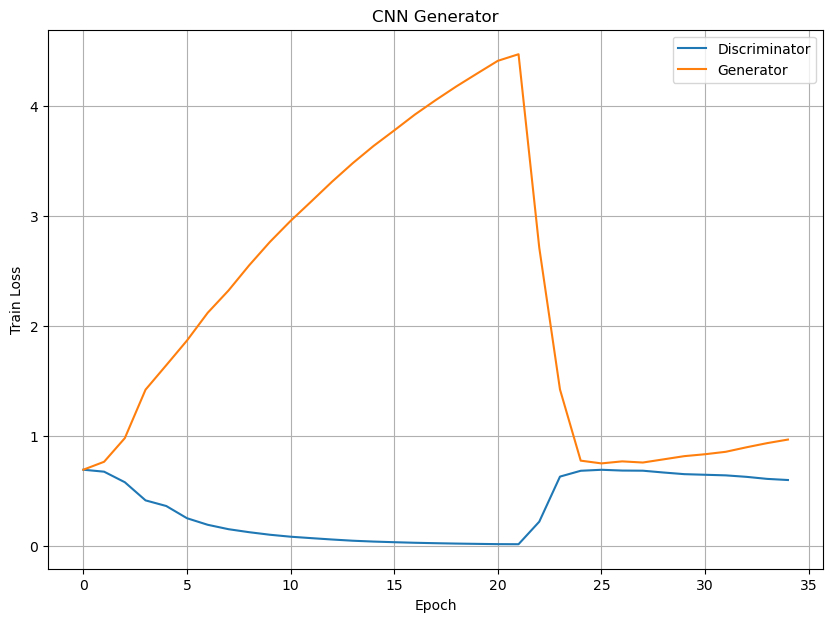

In [11]:
plt.figure(figsize=(10, 7))
plt.plot(d_losses_cnn, label='Discriminator')
plt.plot(g_losses_cnn, label='Generator')
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.title('CNN Generator')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
save_model(generator_cnn, "generator_cnn")

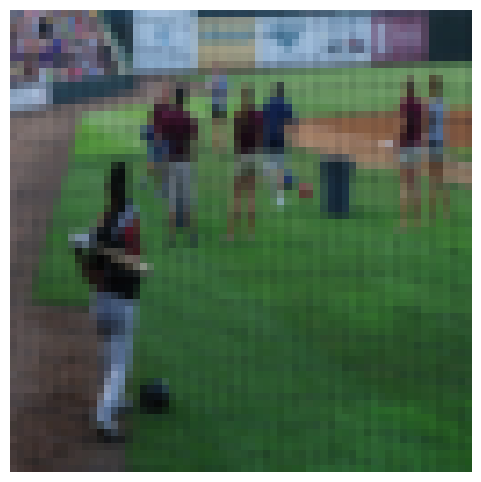

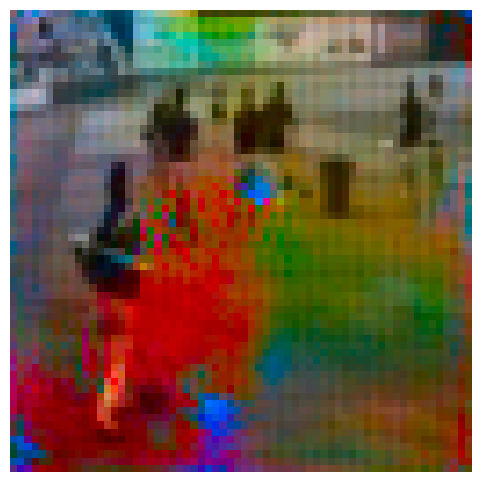

In [14]:
# check for mode collapse:
# so whether we get the same colors to different images
# if so use different loss (wgan)

input = dataset[763][1].to(device).unsqueeze(0)
ab = generator_cnn(input).squeeze(0)
plot_rgb(dataset[763][0])
reconstruct_lab(dataset[763][1].to(device).detach().cpu(), ab.detach().cpu())

In [ ]:
torch.manual_seed(42)
d_losses_encdec, g_losses_encdec = train(small_train_loader, discriminator_cnn, generator_encdec,
                                         disc_cnn_opt, gen_encdec_opt, criterion_bce)

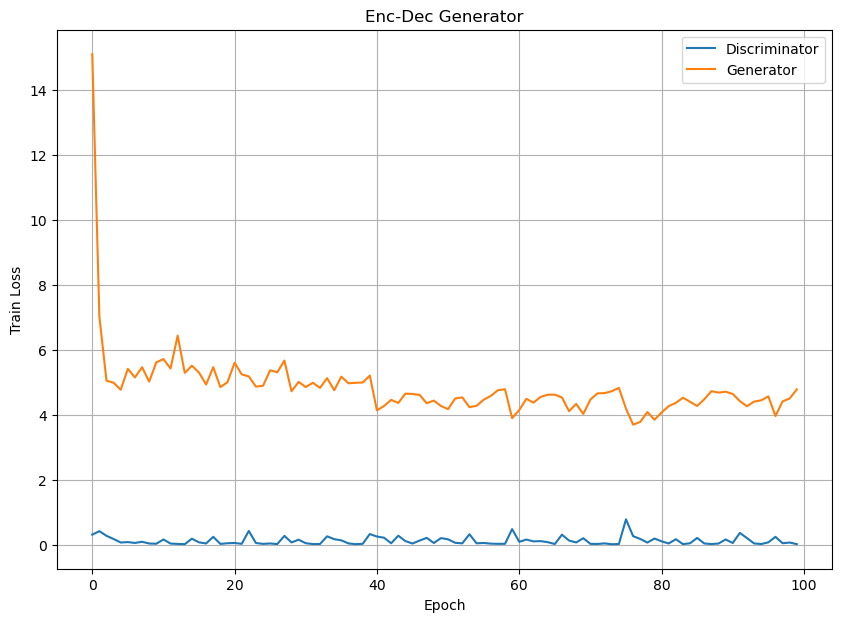

In [12]:
plt.figure(figsize=(10, 7))
plt.plot(d_losses_encdec, label='Discriminator')
plt.plot(g_losses_encdec, label='Generator')
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.title('Encoder-Decoder Generator')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
save_model(generator_encdec, "generator_encdec")

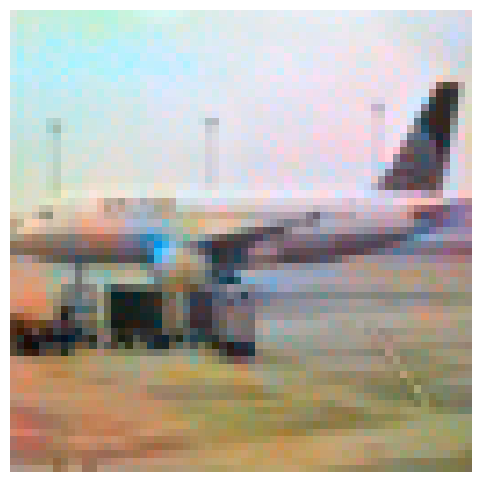

In [30]:
input = dataset[7653][1].to(device).unsqueeze(0)
ab = generator_encdec(input).squeeze(0)
reconstruct_lab(dataset[7653][1].to(device).detach().cpu(), ab.detach().cpu())

# Load and Eval

In [16]:
def eval(loaded_model):
    loaded_model.eval()

    total_mse = 0
    total_psnr = 0
    num_samples = 0

    with torch.no_grad():
        for _, l_channels, _, _, ab_channels in small_test_loader:
            l_channels = l_channels.to(device)
            ab_channels = ab_channels.to(device)

            ab_preds = loaded_model(l_channels)

            mse = F.mse_loss(ab_preds, ab_channels)
            total_mse += mse.item() * ab_channels.size(0)

            max_pixel_value = 1  # image values are between 0 and 1
            psnr = 20 * torch.log10(max_pixel_value**2 / mse)
            total_psnr += psnr.item() * ab_channels.size(0)

            num_samples += ab_channels.size(0)

    avg_mse = total_mse / num_samples
    avg_psnr = total_psnr / num_samples

    print(f"Average MSE: {avg_mse:.4f}")
    print(f"Average PSNR: {avg_psnr:.4f}")
    # note: if you run this cell over and over you get slighly different values in the 
    # decimal places for avg psnr possibly because of numerical errors, since when
    # we divide by mse, that value is very small and then we take the log of that,
    # so there can be "errors" of this type to keep in mind.

GeneratorCNN model loaded successfully!
0.004045562818646431


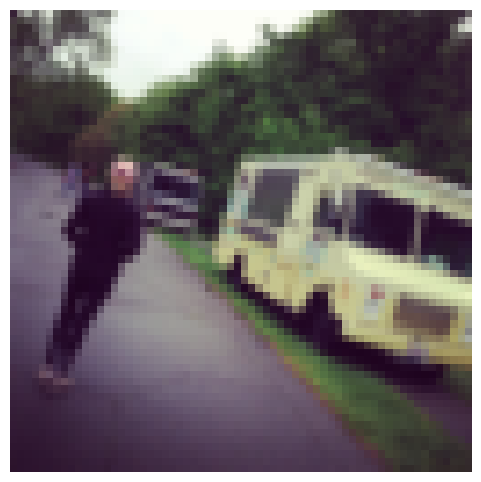

c:\Users\sandr\Desktop\ML\project\image-colorization\utils\plots.py:92: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 2 negative Z values that have been clipped to zero
  rgb_image = lab2rgb(lab_image_reconstructed)


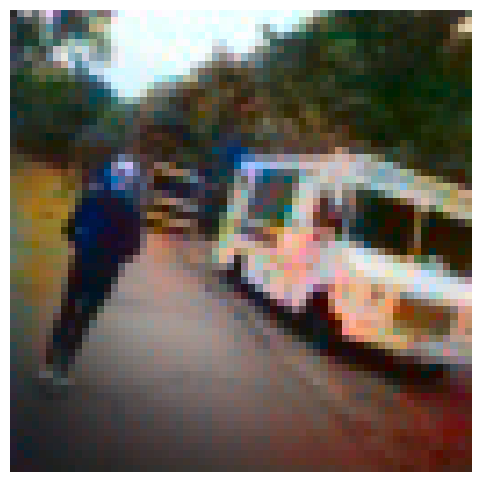

In [17]:
cnn_trained = load_model(GeneratorCNN(), "models/generator_cnn.pth").to(device)
img = dataset[5276]
input = img[1].to(device).unsqueeze(0)
print(F.mse_loss(img[-1].to(device), cnn_trained(input).squeeze(0)).item())
plot_rgb(img[0])
reconstruct_lab(img[1].detach().cpu(), cnn_trained(input).squeeze(0).detach().cpu())

In [18]:
eval(cnn_trained)

Average MSE: 0.0054
Average PSNR: 45.4468


GeneratorEncDec model loaded successfully!
0.004254991188645363


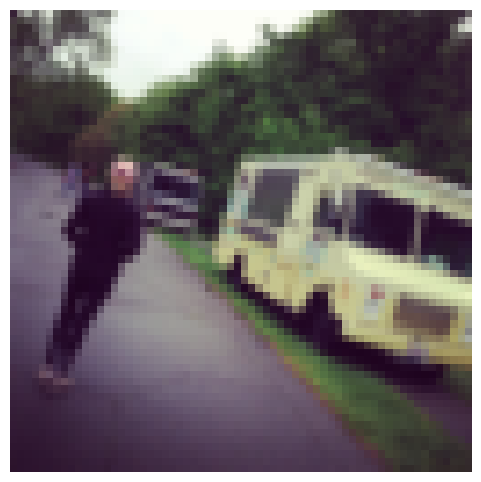

c:\Users\sandr\Desktop\ML\project\image-colorization\utils\plots.py:92: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1 negative Z values that have been clipped to zero
  rgb_image = lab2rgb(lab_image_reconstructed)


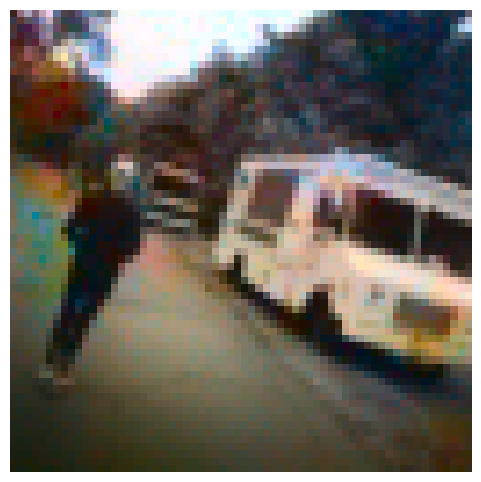

In [19]:
encdec_trained = load_model(GeneratorEncDec(), "models/generator_encdec.pth").to(device)
img = dataset[5276]
input = img[1].to(device).unsqueeze(0)
print(F.mse_loss(img[-1].to(device), encdec_trained(input).squeeze(0)).item())
plot_rgb(img[0])
reconstruct_lab(img[1].detach().cpu(), encdec_trained(input).squeeze(0).detach().cpu())

In [20]:
eval(encdec_trained)

Average MSE: 0.0040
Average PSNR: 47.9351
